# Outline:
* [Configuration](#config)
* [Functions](#functions)
* [Loading-data](#loading-data)
* [Data-manipulation](#manipulation)
* [Representation](#representation)

# Configuration <a class='anchor' id='config'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from helper_functions import load_data, load_main_dataframe, load_yx_dataframe


url_csse_covid_19_daily_reports = ("https://github.com/CSSEGISandData/COVID-19/tree/master/"
                                   "csse_covid_19_data/csse_covid_19_daily_reports")
url_csse_covid_19_daily_reports_us = ("https://github.com/CSSEGISandData/COVID-19/tree/master/"
                                      "csse_covid_19_data/csse_covid_19_daily_reports_us")

url_time_series_covid19_confirmed_global = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
                        "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
url_time_series_covid19_deaths_global = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
                        "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
url_time_series_covid19_recovered_global = ("https://github.com/CSSEGISandData/COVID-19/raw/master/"
 "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

url_time_series_covid19_confirmed_US = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
                        "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
url_time_series_covid19_deaths_US = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
                        "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")

today = datetime.date.today()
yesterday = today - datetime.timedelta(days=1)
url_apple_mobility_trends = ('https://covid19-static.cdn-apple.com/covid19-mobility-data/'
                             f'2009HotfixDev19/v3/en-us/applemobilitytrends-{yesterday}.csv')
url_google_mobility_report = 'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'

# Functions <a class='anchor' id='functions'></a>

In [2]:
def format_columns(df):
    column_mapping = {'sub_region_1': 'province_state', 'sub_region_2': 'county', 'admin2': 'county',
                 'country/region':'country_region', 'province/state': 'province_state', 'long_': 'long'}    
    dates = {}
    names = {}
    for col in df.columns:
        try:
            dates[col] = pd.to_datetime(col).date()
        except:
            names[col] = str.lower(col)
    df = df.rename(columns=names).rename(columns=dates)    
    cols_order = list(names.values()) + sorted(dates.values(), reverse=True)
    df = df[cols_order]
    df = df.rename(columns=column_mapping)
    if 'county' not in df.columns:
        df['county'] = ' '
    df[['country_region', 'province_state', 'county']] = df[['country_region', 'province_state', 'county']].fillna(' ')
    return df

def format_cells(df):
    df = df.copy()
    regex_mapping = {r'\s(r|R)egion$': '', r'\s(s|S)tate$': '', r'(s|S)tate of': '', r'\s(d|D)istrict$': '',
                     r'\s(p|P)rovince$': '', r'\s(c|C)ounty$': '', r'\s(t|T)erritory$': '', 
                     r'\s(d|D)epartment$': '', r'\s(g|G)overnorate$': '', r'\s(m|M)unicipality$': ''}
    name_mapping = {'The Bahamas':'Bahamas', "Côte d'Ivoire":"Cote d'Ivoire", 'Myanmar (Burma)': 'Burma', 
                 'Korea, South': 'South Korea', 'Taiwan*':'Taiwan', 'US': 'United States'}     
    df = df.replace(regex=regex_mapping).replace(to_replace=name_mapping)
    return df

In [3]:
def get_time_series_data(url):
    df = format_cells(format_columns(load_data(url)))
    date_columns = [c for c in df.columns if isinstance(c, datetime.date)]
    # melt: Unpivots a DataFrame from wide format to long format
    df = df.melt(value_vars=date_columns,
                 id_vars=['country_region', 'province_state', 'county'], 
                 var_name='date', 
                 value_name='values')
    df['date'] = pd.to_datetime(df['date'])
    return df.set_index(['country_region', 'province_state', 'county', 'date']).sort_index()

In [4]:
def get_google_mobility_data(url):
    df_mobility = load_data(url, dtype={'country_region': str, 'sub_region_1': str, 'sub_region_2': str})
    df_mobility = format_cells(format_columns(df_mobility))    
    df_mobility.loc[df_mobility['country_region'] == 'Aruba', 
                    ['country_region', 'province_state']] = ('Netherlands', 'Aruba')    
    df_mobility.loc[df_mobility['country_region'] == 'Hong Kong'
                    , ['country_region', 'province_state']] = ('China', 'Hong Kong')
    df_mobility['mobility'] = float(np.nan)
    cols = df_mobility.columns[-7:-1]
    df_mobility['mobility'] = df_mobility[cols].mean(axis=1).div(100.0).round(3)
    df_mobility['date'] = pd.to_datetime(df_mobility['date'])
    df_mobility.drop_duplicates(subset=['country_region', 'province_state', 'county', 'date'], keep='last', inplace=True)
    df_mobility = df_mobility.set_index(['country_region', 'province_state', 'county', 'date']).sort_index()    
    return df_mobility['mobility']

In [5]:
def calculate_baseline(df, based_on_column, start_date, end_date, apply_func):
    assert (apply_func in ['mean', 'median', 'topmean', 'wavg'] or callable(apply_func)), 'invalid apply_func'
    assert (isinstance(start_date, pd.Timestamp) and isinstance(end_date, pd.Timestamp)
           and end_date >= start_date), 'invalid dates'
    
    idx_bp = idx[:, :, :, start_date: end_date]    
    
    if apply_func == 'mean':
        res = df.loc[idx_bp, based_on_column].mean(axis=0, level=[0,1,2])
    
        # slower version of the mean/median format:
        # for name, group in df.groupby(axis='index', level=[0,1,2]):
#         start_index = (*name, start_date)
#         end_index = (*name, end_date)
#         res.loc[name] = df.loc[idx[start_index: end_index], based_on_column].mean()
        
    elif apply_func == 'median':
        res = df.loc[idx_bp, based_on_column].median(axis=0, level=[0,1,2])
        
    elif apply_func == 'topmean':
        # consider the view of the dataframe during start_date/end_date, then use 
        # mean of top N(25%) values for that specific location during this period
        N = int((end_date - start_date).days / 4)
        res = (df.loc[idx_bp, based_on_column]
               .sort_values(ascending=False)
               .groupby(axis=0, level=[0,1,2])
               .head(N)
               .mean(axis=0, level=[0,1,2]))        
        
    elif apply_func == 'wavg':
        wgtavg = lambda x: np.average(x, axis=0, weights=np.arange(1, len(x)+1))
        res = (df.loc[idx_bp, based_on_column]
               .sort_index(level=3)
               .groupby(axis=0, level=[0,1,2])
               .apply(wgtavg))

    else:
        res = (df.loc[idx_bp, based_on_column]               
               .groupby(axis=0, level=[0,1,2])
               .apply(apply_func))
    
    res.loc[(res.isna()) | (res < 0.5)] = 0.5
    return res

# Loading data <a class='anchor' id='loading-data'></a>

**Fetch time series**

In [6]:
%%time
df_global_confirmed = get_time_series_data(url_time_series_covid19_confirmed_global).rename(columns={'values':'confirmed'})
df_global_deaths = get_time_series_data(url_time_series_covid19_deaths_global).rename(columns={'values':'deaths'})
df_us_confirmed = get_time_series_data(url_time_series_covid19_confirmed_US).rename(columns={'values':'confirmed'})
df_us_deaths= get_time_series_data(url_time_series_covid19_deaths_US).rename(columns={'values':'deaths'})

df_confirmed = df_global_confirmed.append(df_us_confirmed)
df_deaths = df_global_deaths.append(df_us_deaths)
df = pd.merge(left=df_confirmed, right=df_deaths, left_index=True, right_index=True, how='inner')

Wall time: 25.5 s


In [7]:
idx = pd.IndexSlice
df.loc[idx['United States', :, :, '2020-06-03']]

confirmed  deaths
province_state county                       
                             1851626  107201
Alabama        Autauga           239       5
               Baldwin           292       9
               Barbour           177       1
               Bibb               76       1
...                              ...     ...
Wyoming        Teton             100       0
               Uinta              13       0
               Unassigned          0      16
               Washakie           37       0
               Weston              1       0

[3262 rows x 2 columns]

**Fill mobility trends in different regions of the world**

In [8]:
%%time
df_mobility = get_google_mobility_data(url_google_mobility_report)

Wall time: 3min 2s


Merge mobility with our main dataframe

In [9]:
%%time
df = pd.merge(left=df, right=df_mobility, left_index=True, right_index=True, how='left', validate='1:1').sort_index()

Wall time: 1.9 s


In [10]:
df.loc[idx['France', :, :, '2020-05-25': '2020-05-27']].tail(7)

confirmed  deaths  \
country_region province_state            county date                            
France         Saint Barthelemy                 2020-05-27          6       0   
               Saint Pierre and Miquelon        2020-05-25          1       0   
                                                2020-05-26          1       0   
                                                2020-05-27          1       0   
               St Martin                        2020-05-25         40       3   
                                                2020-05-26         40       3   
                                                2020-05-27         40       3   

                                                            mobility  
country_region province_state            county date                  
France         Saint Barthelemy                 2020-05-27       NaN  
               Saint Pierre and Miquelon        2020-05-25       NaN  
                                                2020-05-26       NaN  
                                                2020-05-27       NaN  
               St Martin                        2020-05-25       NaN  
                                                2020-05-26       NaN  
                                                2020-05-27       NaN

# Data Manipulation <a class='anchor' id='manipulation'></a>

**Calculating *new_confirmed* and *new_deaths***

In [11]:
%%time
df[['new_confirmed', 'new_deaths']] = df[['confirmed', 'deaths']].diff()

Wall time: 34.9 ms


In [12]:
%%time
headindex, tailindex = [], []
for name, group in df.groupby(axis='index', level=[0,1,2]):    
    headindex.append(group.index.values[0])
    tailindex.append(group.index.values[-1])

headindex = pd.MultiIndex.from_tuples(headindex)
tailindex = pd.MultiIndex.from_tuples(tailindex)

df.loc[headindex, 'new_confirmed'] = df.loc[headindex, 'confirmed']
df.loc[headindex, 'new_deaths'] = df.loc[headindex, 'deaths']

df['new_deaths'] = df['new_deaths'].astype('int64')
df['new_confirmed'] = df['new_confirmed'].astype('int64')
df = df[['mobility', 'confirmed', 'new_confirmed', 'deaths', 'new_deaths']]

Wall time: 5.21 s


**Calculating a *baseline*, and change rates of deaths/confirmed based on this baseline**

In [13]:
baseline_function = 'wavg'
baseline_start_date = pd.to_datetime('2020-01-01')
baseline_end_date = df.index.levels[3].max() - pd.Timedelta('7 days')
print(f'baseline period: {baseline_start_date} to {baseline_end_date}')
df['baseline_info_'] = f'{baseline_function}:{baseline_start_date.date()}_{baseline_end_date.date()}'

baseline period: 2020-01-01 00:00:00 to 2020-06-05 00:00:00


In [14]:
%%time
df['n_c_baseline_'] = calculate_baseline(df, based_on_column='new_confirmed', 
                                         start_date=baseline_start_date, end_date=baseline_end_date, 
                                         apply_func=baseline_function)
df['n_d_baseline_'] = calculate_baseline(df, based_on_column='new_deaths', 
                                         start_date=baseline_start_date, end_date=baseline_end_date, 
                                         apply_func=baseline_function)

Wall time: 6 s


In [15]:
df['n_c_change'] = (((df['new_confirmed'] - df['n_c_baseline_']) / df['n_c_baseline_'])
                                    .round(3))
df['n_d_change'] = (((df['new_deaths'] - df['n_d_baseline_']) / df['n_d_baseline_'])
                                .round(3))

We calculate location's *shock_index* as the weighted average of *n_d_change* of the _k_ newsest reports

In [16]:
%%time
k = 10
weights = np.arange(1, k+1)
df['shock'] = np.nan
df['alert'] = np.nan
wavg = lambda x: np.average(x.iloc[-k:], weights=weights, axis=0)
df_temp = df.sort_index(level=3)
df['shock'] = df_temp['n_d_change'].groupby(axis=0, level=[0,1,2]).apply(wavg)
df['alert'] = df_temp['n_c_change'].groupby(axis=0, level=[0,1,2]).apply(wavg)

# slower version:
# for name, group in df.groupby(axis=0, level=[0,1,2]):
#     df.loc[name, 'shock'] = np.average(group.iloc[-k:]['n_d_change'], weights=weights, axis=0)
#     df.loc[name, 'growth'] = np.average(group.iloc[-k:]['n_c_change'], weights=weights, axis=0)

Wall time: 4.47 s


Clean up dataframe

In [17]:
# rearrange df
df = df[['mobility', 
         'confirmed', 'new_confirmed', 'n_c_change', 
         'deaths', 'new_deaths', 'n_d_change', 'shock', 'alert', 
         'n_c_baseline_', 'n_d_baseline_', 'baseline_info_']]
df.loc[idx['Afghanistan': 'Angola'],]

mobility  confirmed  \
country_region province_state county date                              
Afghanistan                          2020-01-22       NaN          0   
                                     2020-01-23       NaN          0   
                                     2020-01-24       NaN          0   
                                     2020-01-25       NaN          0   
                                     2020-01-26       NaN          0   
...                                                   ...        ...   
Angola                               2020-06-08       NaN         92   
                                     2020-06-09       NaN         96   
                                     2020-06-10       NaN        113   
                                     2020-06-11       NaN        118   
                                     2020-06-12       NaN        130   

                                                 new_confirmed  n_c_change  \
country_region province_state county date                                    
Afghanistan                          2020-01-22              0      -1.000   
                                     2020-01-23              0      -1.000   
                                     2020-01-24              0      -1.000   
                                     2020-01-25              0      -1.000   
                                     2020-01-26              0      -1.000   
...                                                        ...         ...   
Angola                               2020-06-08              1       0.028   
                                     2020-06-09              4       3.111   
                                     2020-06-10             17      16.473   
                                     2020-06-11              5       4.139   
                                     2020-06-12             12      11.334   

                                                 deaths  new_deaths  \
country_region province_state county date                             
Afghanistan                          2020-01-22       0           0   
                                     2020-01-23       0           0   
                                     2020-01-24       0           0   
                                     2020-01-25       0           0   
                                     2020-01-26       0           0   
...                                                 ...         ...   
Angola                               2020-06-08       4           0   
                                     2020-06-09       4           0   
                                     2020-06-10       4           0   
                                     2020-06-11       5           1   
                                     2020-06-12       5           0   

                                                 n_d_change     shock  \
country_region province_state county date                               
Afghanistan                          2020-01-22        -1.0  3.929818   
                                     2020-01-23        -1.0  3.929818   
                                     2020-01-24        -1.0  3.929818   
                                     2020-01-25        -1.0  3.929818   
                                     2020-01-26        -1.0  3.929818   
...                                                     ...       ...   
Angola                               2020-06-08        -1.0 -0.672727   
                                     2020-06-09        -1.0 -0.672727   
                                     2020-06-10        -1.0 -0.672727   
                                     2020-06-11         1.0 -0.672727   
                                     2020-06-12        -1.0 -0.672727   

                                                    alert  n_c_baseline_  \
country_region province_state county date                                  
Afghanistan                          2020-01-22  1.802309     242.38804

**Saving DF dataset:**

In [18]:
%%time
print('Dataset shape:', df.shape)
print('Dataset columns: ', df.columns.ravel())
today = datetime.datetime.today().date()
df.to_csv(f'datasets/{today}_covid19_stats.csv', index=True)
# pd.testing.assert_frame_equal(df, load_main_dataframe(today))

Dataset shape: (504361, 12)
Dataset columns:  ['mobility' 'confirmed' 'new_confirmed' 'n_c_change' 'deaths' 'new_deaths'
 'n_d_change' 'shock' 'alert' 'n_c_baseline_' 'n_d_baseline_'
 'baseline_info_']
Wall time: 8.21 s


**Building DF_YX:**

In [19]:
%%time
df = load_main_dataframe(today)

Wall time: 4.54 s


Let's first get rid of those places that have no *mobility* data

In [20]:
%%time
df = df.loc[~df['mobility'].isna().all(axis=0, level=[0,1,2])]

Wall time: 2.95 s


Let's find the last date that *mobility* data is available (which is not necessarily the lastest date in the dataset)

In [21]:
closing_date = df.loc[~df['mobility'].isna()].index.max()[3]

Now, we use final week values for indicator, and previous 4 weeks as feature values

In [22]:
week = pd.Timedelta('7 days')
day = pd.Timedelta('1 day')

x_period = (closing_date - 5 * week - day, closing_date - week - day)
y_period = (closing_date - week, closing_date)
print('X period:', x_period)
print('Y period:', y_period)
df_x = df.loc[idx[:,:,:, x_period[0]: x_period[1]], ['mobility', 'n_c_change', 'n_d_change']].copy()
df_y = df.loc[idx[:,:,:, y_period[0]: y_period[1]], ['n_c_baseline_', 'n_d_baseline_','mobility', 'n_c_change', 'n_d_change']].copy()

X period: (Timestamp('2020-05-02 00:00:00'), Timestamp('2020-05-30 00:00:00'))
Y period: (Timestamp('2020-05-31 00:00:00'), Timestamp('2020-06-07 00:00:00'))


*df_y*

In [23]:
df_y = df_y.mean(axis=0, level=[0,1,2])
df_y.columns = df_y.columns[:2].tolist() + [f'avg({c})' for c in df_y.columns[2:]]
df_y['Y_period'] = f'{y_period[0].date()}_{y_period[1].date()}'
df_y['X_period'] = f'{x_period[0].date()}_{x_period[1].date()}'
df_y.head(3)

,,,n_c_baseline_,n_d_baseline_,avg(mobility),avg(n_c_change),avg(n_d_change),Y_period,X_period
country_region,province_state,county,,,,,,,
Afghanistan,,,242.388042,3.758265,-0.316375,1.999625,2.592,2020-05-31_2020-06-07,2020-05-02_2020-05-30
Angola,,,0.972950,0.500000,-0.101125,-0.100625,-1.000,2020-05-31_2020-06-07,2020-05-02_2020-05-30
Antigua and Barbuda,,,0.500000,0.500000,-0.289125,-0.750000,-1.000,2020-05-31_2020-06-07,2020-05-02_2020-05-30


*df_x*

In [24]:
df_x = (df_x
        .reset_index()
        .pivot_table(values=['mobility', 'n_c_change', 'n_d_change'], 
                     index=['country_region', 'province_state', 'county'], 
                     columns=['date']))
df_x.columns = [f'X_{x[0]}_{x[1].date()}' for x in df_x.columns]

In [25]:
df_x.head(3)

,,,X_mobility_2020-05-02,X_mobility_2020-05-03,X_mobility_2020-05-04,X_mobility_2020-05-05,X_mobility_2020-05-06,X_mobility_2020-05-07,X_mobility_2020-05-08,X_mobility_2020-05-09,X_mobility_2020-05-10,X_mobility_2020-05-11,...,X_n_d_change_2020-05-21,X_n_d_change_2020-05-22,X_n_d_change_2020-05-23,X_n_d_change_2020-05-24,X_n_d_change_2020-05-25,X_n_d_change_2020-05-26,X_n_d_change_2020-05-27,X_n_d_change_2020-05-28,X_n_d_change_2020-05-29,X_n_d_change_2020-05-30
country_region,province_state,county,,,,,,,,,,,,,,,,,,,,,
Afghanistan,,,-0.270,-0.295,-0.267,-0.272,-0.255,-0.252,-0.175,-0.227,-0.247,-0.217,...,0.596,2.193,1.927,-0.468,-0.734,-0.734,0.863,1.129,1.927,-0.202
Angola,,,-0.177,-0.280,-0.247,-0.225,-0.237,-0.200,-0.237,-0.158,-0.265,-0.233,...,-1.000,-1.000,1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
Antigua and Barbuda,,,-0.446,-0.514,-0.674,-0.318,-0.280,-0.298,-0.273,-0.388,-0.434,-0.302,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000


*df_yx*

In [26]:
df_yx = (pd.merge(left=df_y, right=df_x, left_index=True, right_index=True, how='inner')
         .reset_index())
df_yx[['country_region', 'province_state', 'county']] = \
                df_yx[['country_region', 'province_state', 'county']].replace('nan', '')
df_yx['country_region'] = df_yx['country_region'] + df_yx['province_state'] + df_yx['county']
df_yx = df_yx.drop(axis=1, labels=['province_state', 'county']).rename(columns={'country_region':'location'})
df_yx.head(3)

,location,n_c_baseline_,n_d_baseline_,avg(mobility),avg(n_c_change),avg(n_d_change),Y_period,X_period,X_mobility_2020-05-02,X_mobility_2020-05-03,...,X_n_d_change_2020-05-21,X_n_d_change_2020-05-22,X_n_d_change_2020-05-23,X_n_d_change_2020-05-24,X_n_d_change_2020-05-25,X_n_d_change_2020-05-26,X_n_d_change_2020-05-27,X_n_d_change_2020-05-28,X_n_d_change_2020-05-29,X_n_d_change_2020-05-30
0,Afghanistan,242.388042,3.758265,-0.316375,1.999625,2.592,2020-05-31_2020-06-07,2020-05-02_2020-05-30,-0.270,-0.295,...,0.596,2.193,1.927,-0.468,-0.734,-0.734,0.863,1.129,1.927,-0.202
1,Angola,0.972950,0.500000,-0.101125,-0.100625,-1.000,2020-05-31_2020-06-07,2020-05-02_2020-05-30,-0.177,-0.280,...,-1.000,-1.000,1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
2,Antigua and Barbuda,0.500000,0.500000,-0.289125,-0.750000,-1.000,2020-05-31_2020-06-07,2020-05-02_2020-05-30,-0.446,-0.514,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000


**Saving DF_YX dataset:**

In [27]:
print('Dataset shape:', df_yx.shape)
print('Dataset columns: ', df_yx.columns)
today = datetime.datetime.today().date()
df_yx.to_csv(f'datasets/{today}_covid19_ml.csv', index=False)
# assert(df_yx.equals(load_yx_dataframe(today))), 'Saved dataset does not match newly loaded one'

Dataset shape: (2911, 95)
Dataset columns:  Index(['location', 'n_c_baseline_', 'n_d_baseline_', 'avg(mobility)',
       'avg(n_c_change)', 'avg(n_d_change)', 'Y_period', 'X_period',
       'X_mobility_2020-05-02', 'X_mobility_2020-05-03',
       'X_mobility_2020-05-04', 'X_mobility_2020-05-05',
       'X_mobility_2020-05-06', 'X_mobility_2020-05-07',
       'X_mobility_2020-05-08', 'X_mobility_2020-05-09',
       'X_mobility_2020-05-10', 'X_mobility_2020-05-11',
       'X_mobility_2020-05-12', 'X_mobility_2020-05-13',
       'X_mobility_2020-05-14', 'X_mobility_2020-05-15',
       'X_mobility_2020-05-16', 'X_mobility_2020-05-17',
       'X_mobility_2020-05-18', 'X_mobility_2020-05-19',
       'X_mobility_2020-05-20', 'X_mobility_2020-05-21',
       'X_mobility_2020-05-22', 'X_mobility_2020-05-23',
       'X_mobility_2020-05-24', 'X_mobility_2020-05-25',
       'X_mobility_2020-05-26', 'X_mobility_2020-05-27',
       'X_mobility_2020-05-28', 'X_mobility_2020-05-29',
       'X_mobility_

# Representation <a class='anchor' id='representation'></a>

In [28]:
%matplotlib inline

In [29]:
df = load_main_dataframe()
df.columns

Index(['mobility', 'confirmed', 'new_confirmed', 'n_c_change', 'deaths',
       'new_deaths', 'n_d_change', 'shock', 'alert', 'n_c_baseline_',
       'n_d_baseline_', 'baseline_info_'],
      dtype='object')

In [30]:
shocks = df['shock'].groupby(axis=0, level=[0,1,2]).agg(np.max).sort_values(ascending=False)
alerts = df['alert'].groupby(axis=0, level=[0,1,2]).agg(np.max).sort_values(ascending=False)

new confirmed baseline: 1890.7
new deaths baseline: 200.8


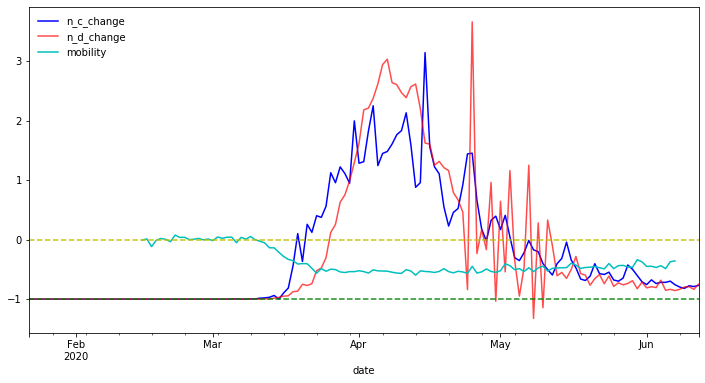

In [31]:
nidx = idx['United States', 'New York','New York']

df.loc[nidx, 'n_c_change'].plot(figsize=(12, 6), c='b')
df.loc[nidx, 'n_d_change'].plot(figsize=(12, 6), c='r', alpha=0.7)
df.loc[nidx, 'mobility'].plot(figsize=(12, 6), c='c')
plt.axhline(y=0, color='y', alpha=0.9, linestyle='--')
plt.axhline(y=-1, color='g', alpha=0.9, linestyle='--')
plt.legend(loc='upper left', frameon=False)
print('new confirmed baseline:', df.loc[nidx, 'n_c_baseline_'].values[0].round(1))
print('new deaths baseline:', df.loc[nidx, 'n_d_baseline_'].values[0].round(1))

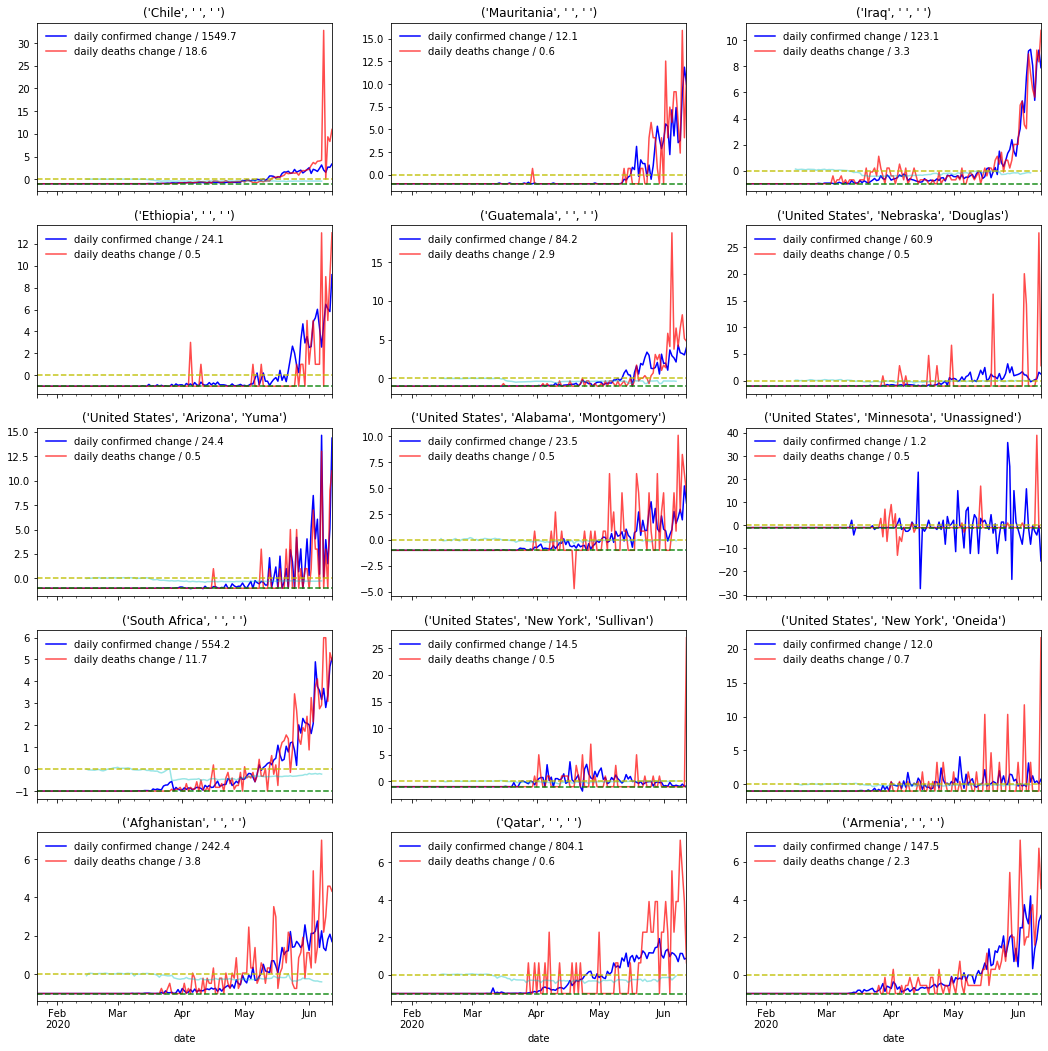

In [32]:
spr = 5
spc = 3
fig, axes = plt.subplots(spr, spc, sharex=True, figsize=(18,18))

for i, j in ((i,j) for i in range(spr) for j in range(spc)):
    nidx = shocks.index.values[i*spc + j]
    ncb, ndb = df.loc[nidx, ['n_c_baseline_', 'n_d_baseline_']].values[0].round(1).ravel()
    df.loc[nidx, 'n_c_change'].plot(ax=axes[i,j], c='b')
    df.loc[nidx, 'n_d_change'].plot(ax=axes[i,j], c='r', alpha=0.7)
    df.loc[nidx, 'mobility'].plot(ax=axes[i,j], c='c', alpha=0.4)
    axes[i, j].legend(loc='upper left', frameon=False, 
                      labels=[f'daily confirmed change / {ncb}', f'daily deaths change / {ndb}'])
    
    axes[i, j].axhline(y=0, color='y', alpha=0.9, linestyle='--')
    axes[i, j].axhline(y=-1, color='g', alpha=0.9, linestyle='--')
    axes[i, j].set_title(f'{shocks.index[i*spc + j]}')

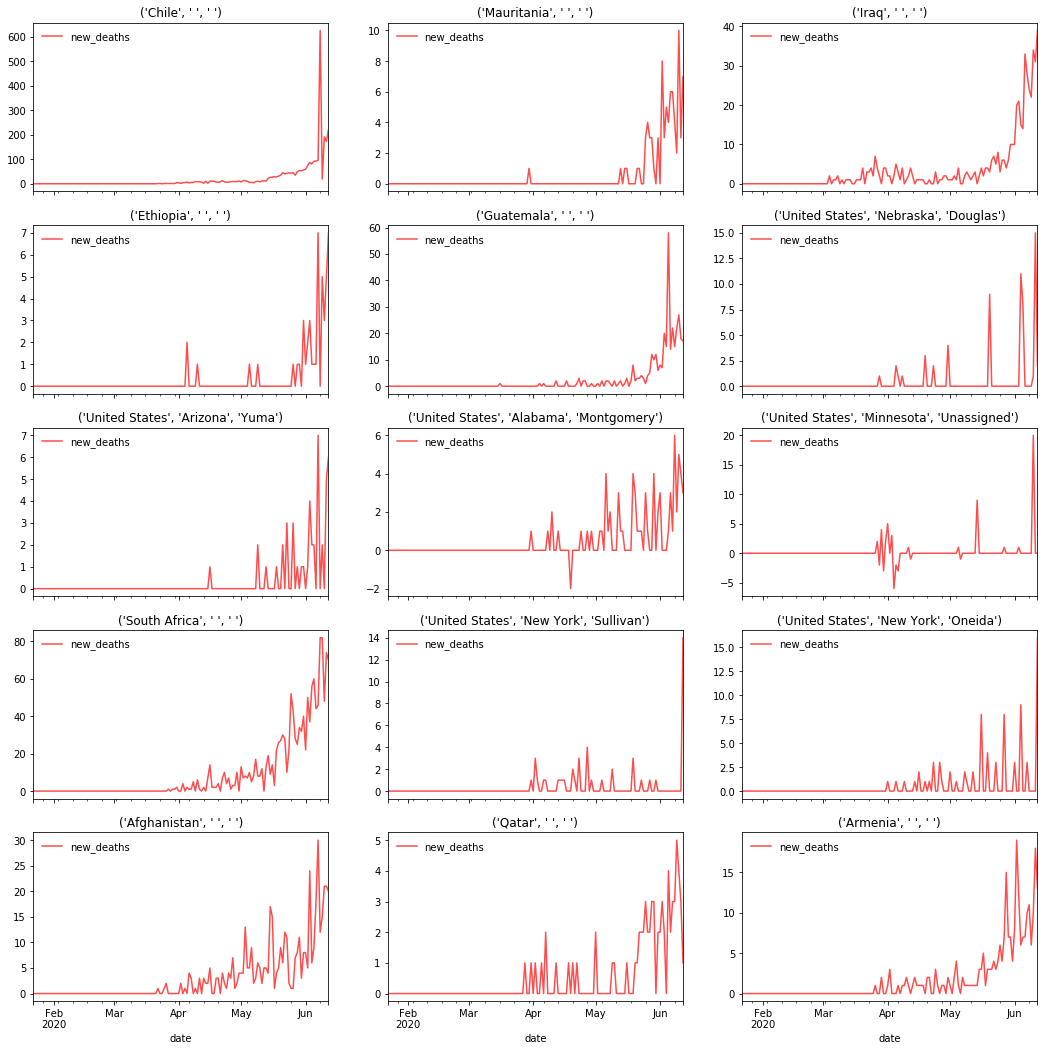

In [33]:
spr = 5
spc = 3
fig, axes = plt.subplots(spr, spc, sharex=True, figsize=(18,18))

for i, j in ((i,j) for i in range(spr) for j in range(spc)):
    nidx = shocks.index.values[i*spc + j]    
    df.loc[nidx, 'new_deaths'].plot(ax=axes[i,j], c='r', alpha=0.7)    
    axes[i, j].legend(loc='upper left', frameon=False)    
    axes[i, j].set_title(f'{shocks.index[i*spc + j]}')

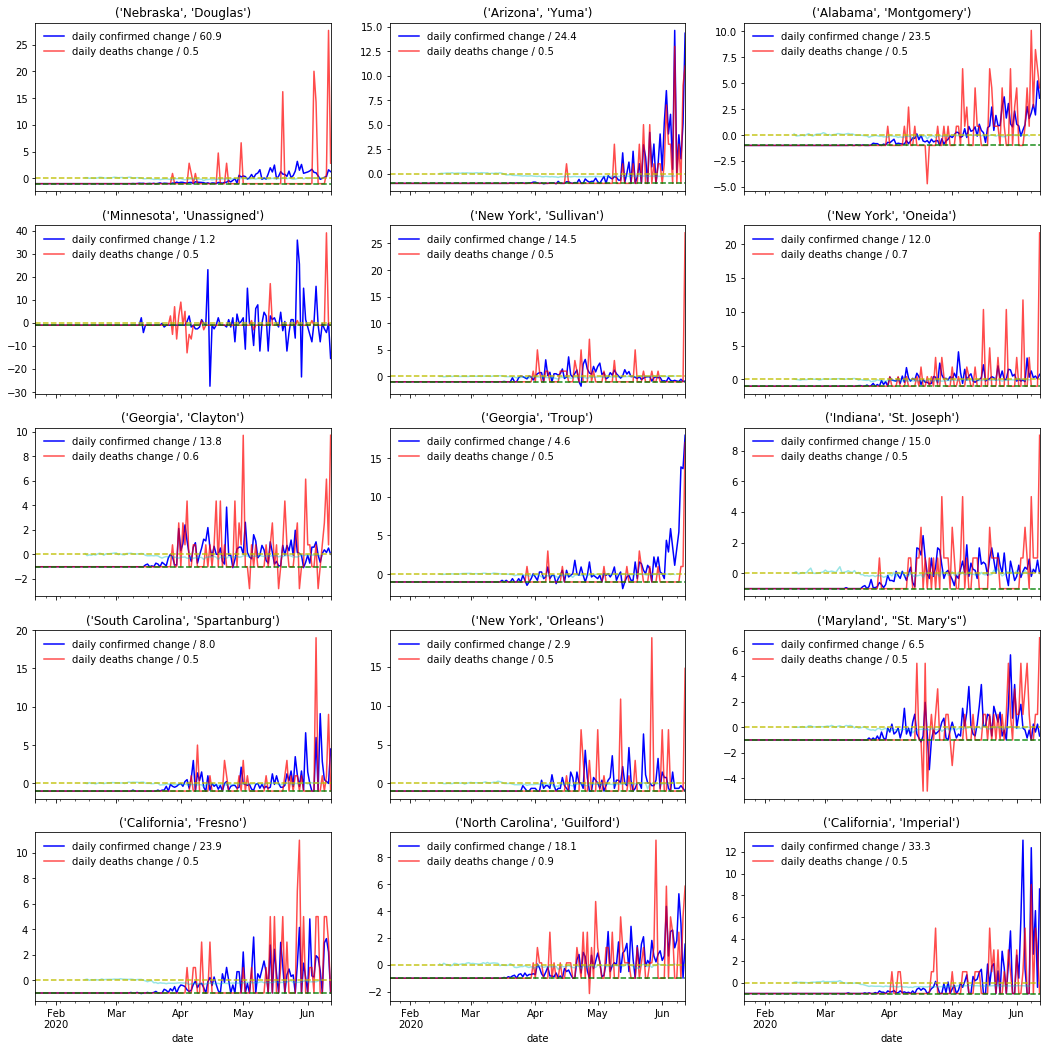

In [34]:
spr = 5
spc = 3
fig, axes = plt.subplots(spr, spc, sharex=True, figsize=(18,18))

us_shocks = shocks.loc[idx['United States', :, :]]
for i, j in ((i,j) for i in range(spr) for j in range(spc)):    
    nidx = us_shocks.index.values[i*spc + j]
    nidx = ('United States', *nidx)
    ncb, ndb = df.loc[nidx, ['n_c_baseline_', 'n_d_baseline_']].values[0].round(1).ravel()
    df.loc[nidx, 'n_c_change'].plot(ax=axes[i,j], c='b')
    df.loc[nidx, 'n_d_change'].plot(ax=axes[i,j], c='r', alpha=0.7)
    df.loc[nidx, 'mobility'].plot(ax=axes[i,j], c='c', alpha=0.4)
    axes[i, j].legend(loc='upper left', frameon=False, 
                      labels=[f'daily confirmed change / {ncb}', f'daily deaths change / {ndb}'])
    
    axes[i, j].axhline(y=0, color='y', alpha=0.9, linestyle='--')
    axes[i, j].axhline(y=-1, color='g', alpha=0.9, linestyle='--')
    axes[i, j].set_title(f'{us_shocks.index[i*spc + j]}')